## Example for training Spiking MLP on IBM Gesture classification
### The problem:
In IBM Gesture dataset (available for download at: [http://research.ibm.com/dvsgesture/](http://research.ibm.com/dvsgesture/)) .
The dataset contains 29 different subjects performing 10 different gestures and one random gesture, capured using DVS128 sensor under 3 different illumination conditions.
The task is to classify the gestures.
Here, we will use first 1.45 s worth of action data to train and test.

## Load proper paths for SLAYER Pytorch source modules¶

In [1]:
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../../src")

## Load required modules
* SLAYER modules are available as `snn`.{`layer`, `params`, `loss`, `predict`, `io`}
* SLAYER-Loihi module implements `spikeLayer` (defines custom Loihi neuron behaviour) and `quantizeWeights` (defines weight quantization scheme)
* Optimizer implements custom NADAM optimizer

In [2]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import slayerSNN as snn
from slayerSNN import loihi as spikeLayer
from slayerSNN import quantize as quantizeParams
from slayerSNN import learningStats as learningStats
from slayerSNN import optimizer as optimizer
# from slayerLoihi import spikeLayer
# from quantizeParams import quantizeWeights
# from learningStats import learningStats
# import optimizer

## Read SNN configuration from yaml file

See the file for all the configuration parameters. This configuration file will be used to describe the SNN. The network configuration file (`network.yaml`) looks like this:

```python
simulation:
    Ts: 1.0
    tSample: 1450
neuron:
    type:     LOIHI
    vThMant:  80 # 5
    vDecay:   128
    iDecay:   1024
    refDelay: 1
    wgtExp:   0
    tauRho:   1     # relative to theta 
    scaleRho: 1
training:
    error:
        type: NumSpikes #ProbSpikes #NumSpikes
        tgtSpikeRegion: {start: 0, stop: 1450}    # only valid for NumSpikes and ProbSpikes
        tgtSpikeCount: {true: 180, false: 30}    # only valid for NumSpikes
    path:
        in:      /neuromorphic/shared/Datasets/IBMGesture/DvsGesture_converted_to_bs2_1450/DvsGestureRaw/
        train:   /neuromorphic/shared/Datasets/IBMGesture/DvsGesture_converted_to_bs2_1450/train.txt
        test:    /neuromorphic/shared/Datasets/IBMGesture/DvsGesture_converted_to_bs2_1450/test.txt
```     
**NOTE: The path need to be modified to match your system**

In [3]:
netParams = snn.params('network.yaml')

## Dataset Definition
The dataset definition follows standard PyTorch dataset definition. Internally, it utilizes `snn.io` modules to read spikes and returns the spike in correct tensor format (`CHWT`).
* `datasetPath`: the path where the spike files are stored.
* `sampleFile`: the file that contains a list of sample indices and its corresponding clases.
* `samplingTime`: the sampling time (in ms) to bin the spikes.
* `sampleLength`: the length of the sample (in ms)

Note: This is a simple dataset class. A dataset that utilizes the folder hierarchy or xml list is easy to create just like any other PyTorch dataset definition.

In [4]:
class IBMGestureDataset(Dataset):
    def __init__(self, datasetPath, sampleFile, samplingTime, sampleLength):
        self.path = datasetPath 
        self.samples = np.loadtxt(sampleFile).astype('int')
        self.samplingTime = samplingTime
        self.nTimeBins    = int(sampleLength / samplingTime)

    def __getitem__(self, index):
        # Read inoput and label
        inputIndex  = self.samples[index, 0]
        classLabel  = self.samples[index, 1]
        # Read input spike
        inputSpikes = snn.io.read2Dspikes(
                        self.path + str(inputIndex.item()) + '.bs2'
                        ).toSpikeTensor(torch.zeros((2,128,128,self.nTimeBins)),
                        samplingTime=self.samplingTime)
        # Create one-hot encoded desired matrix
        desiredClass = torch.zeros((11, 1, 1, 1))
        desiredClass[classLabel,...] = 1
        
        return inputSpikes, desiredClass, classLabel

    def __len__(self):
        return self.samples.shape[0]

## Define the network
The network definition follows similar style as standard PyTorch network definition, but it utilizes snn modules.

In [5]:
class Network(torch.nn.Module):
    def __init__(self, netParams):
        super(Network, self).__init__()
        # initialize slayer
        slayer = spikeLayer(netParams['neuron'], netParams['simulation'])
        self.slayer = slayer
        # define network functions
        self.conv1 = slayer.conv(2, 16, 5, padding=2, weightScale=10)
        self.conv2 = slayer.conv(16, 32, 3, padding=1, weightScale=50)
        self.pool1 = slayer.pool(4)
        self.pool2 = slayer.pool(2)
        self.pool3 = slayer.pool(2)
        self.fc1   = slayer.dense((8*8*32), 512)
        self.fc2   = slayer.dense(512, 11)
        self.drop  = slayer.dropout(0.1)

    def forward(self, spikeInput):
        spike = self.slayer.spikeLoihi(self.pool1(spikeInput )) # 32, 32, 2
        spike = self.slayer.delayShift(spike, 1)
        
        spike = self.drop(spike)
        spike = self.slayer.spikeLoihi(self.conv1(spike)) # 32, 32, 16
        spike = self.slayer.delayShift(spike, 1)
        
        spike = self.slayer.spikeLoihi(self.pool2(spike)) # 16, 16, 16
        spike = self.slayer.delayShift(spike, 1)
        
        spike = self.drop(spike)
        spike = self.slayer.spikeLoihi(self.conv2(spike)) # 16, 16, 32
        spike = self.slayer.delayShift(spike, 1)
        
        spike = self.slayer.spikeLoihi(self.pool3(spike)) #  8,  8, 32
        spike = spike.reshape((spike.shape[0], -1, 1, 1, spike.shape[-1]))
        spike = self.slayer.delayShift(spike, 1)
        
        spike = self.drop(spike)
        spike = self.slayer.spikeLoihi(self.fc1  (spike)) # 512
        spike = self.slayer.delayShift(spike, 1)
        
        spike = self.slayer.spikeLoihi(self.fc2  (spike)) # 11
        spike = self.slayer.delayShift(spike, 1)
        
        return spike

## Initialize the network
* Define the device to run the code on.
* Create network instance.
* Create loss instance.
* Define optimizer module.
* Define training and testing dataloader.
* Cereate instance for learningStats.

In [6]:
# Define the cuda device to run the code on.
device = torch.device('cuda')
# deviceIds = [2, 3]

# Create network instance.
net = Network(netParams).to(device)
# net = torch.nn.DataParallel(Network(netParams).to(device), device_ids=deviceIds)

# Create snn loss instance.
error = snn.loss(netParams, spikeLayer).to(device)

# Define optimizer module.
optimizer = torch.optim.Adam(net.parameters(), lr = 0.01, amsgrad = True)
# optimizer = optimizer.Nadam(net.parameters(), lr = 0.01, amsgrad = True)

# Dataset and dataLoader instances.
trainingSet = IBMGestureDataset(datasetPath =netParams['training']['path']['in'], 
                                sampleFile  =netParams['training']['path']['train'],
                                samplingTime=netParams['simulation']['Ts'],
                                sampleLength=netParams['simulation']['tSample'])
trainLoader = DataLoader(dataset=trainingSet, batch_size=4, shuffle=True, num_workers=1)

testingSet = IBMGestureDataset(datasetPath  =netParams['training']['path']['in'], 
                               sampleFile  =netParams['training']['path']['test'],
                               samplingTime=netParams['simulation']['Ts'],
                               sampleLength=netParams['simulation']['tSample'])
testLoader = DataLoader(dataset=testingSet, batch_size=4, shuffle=True, num_workers=1)

# Learning stats instance.
stats = learningStats()

Max PSP kernel: 195.0
Scaling neuron[scaleRho] by Max PSP Kernel @slayerLoihi
Max PSP kernel: 195.0
Scaling neuron[scaleRho] by Max PSP Kernel @slayerLoihi


## Visualize the spike data
Visualize the first five samples of the dataset.

`snn.io.showTD` should show an animation of the sequence in normal python session.

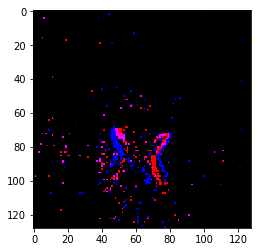

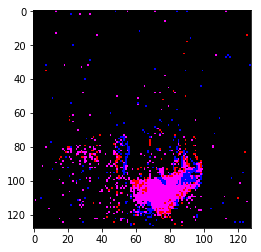

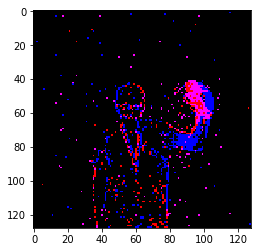

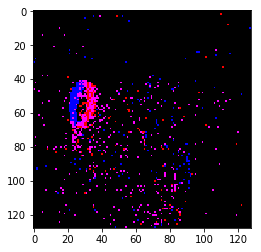

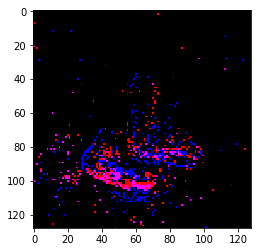

In [7]:
# Visualize the input spikes (first five samples).
for i in range(5):
    input, target, label = trainingSet[i]
    snn.io.showTD(snn.io.spikeArrayToEvent(input.reshape((2, 128, 128, -1)).cpu().data.numpy()))

## Train the network
* Train the network for 100 epochs.
* Best network is stored for inferencing later

In [8]:
for epoch in range(50):
    tSt = datetime.now()

    # Training loop.
    for i, (input, target, label) in enumerate(trainLoader, 0):
        net.train()
        
        # Move the input and target to correct GPU.
        input  = input.to(device)
        target = target.to(device) 

        # Forward pass of the network.
        output = net.forward(input)

        # Gather the training stats.
        stats.training.correctSamples += torch.sum( snn.predict.getClass(output) == label ).data.item()
        stats.training.numSamples     += len(label)

        # Calculate loss.
        loss = error.numSpikes(output, target)

        # Reset gradients to zero.
        optimizer.zero_grad()

        # Backward pass of the network.
        loss.backward()

        # Update weights.
        optimizer.step()

        # Gather training loss stats.
        stats.training.lossSum += loss.cpu().data.item()

        # Display training stats. (Suitable for normal python implementation)
        # if i%10 == 0: stats.print(epoch, i, (datetime.now() - tSt).total_seconds())

    # Testing loop.
    # Same steps as Training loops except loss backpropagation and weight update.
    for i, (input, target, label) in enumerate(testLoader, 0):
        net.eval()
        
        input  = input.to(device)
        target = target.to(device) 

        output = net.forward(input)

        stats.testing.correctSamples += torch.sum( snn.predict.getClass(output) == label ).data.item()
        stats.testing.numSamples     += len(label)

        loss = error.numSpikes(output, target)
        stats.testing.lossSum += loss.cpu().data.item()
        # if i%10 == 0:	stats.print(epoch, i)

    # Update testing stats.
    if epoch%10==0:  stats.print(epoch, timeElapsed=(datetime.now() - tSt).total_seconds())
    stats.update()
    if stats.training.bestLoss is True: torch.save(net.state_dict(), 'Trained/ibmGestureNet.pt')


Epoch :          0,  556374.9890 ms elapsed
loss = 16.379                             	accuracy = 0.087279                     
loss = 14.104                             	accuracy = 0.11742                      

Epoch :         10,  544851.5540 ms elapsed
loss = 13.948       (min = 13.772      )  	accuracy = 0.10864    (max = 0.17734   )
loss = 14.157       (min = 13.948      )  	accuracy = 0.11364    (max = 0.14015   )

Epoch :         20,  544811.9650 ms elapsed
loss = 13.469       (min = 13.367      )  	accuracy = 0.15599    (max = 0.17734   )
loss = 13.453       (min = 13.358      )  	accuracy = 0.15152    (max = 0.16667   )

Epoch :         30,  544602.5370 ms elapsed
loss = 13.027       (min = 12.919      )  	accuracy = 0.17084    (max = 0.23863   )
loss = 13.504       (min = 13.222      )  	accuracy = 0.15152    (max = 0.20455   )

Epoch :         40,  542862.5240 ms elapsed
loss = 11.475       (min = 11.823      )  	accuracy = 0.31383    (max = 0.31012   )
loss = 12.161      

## Plot the Results

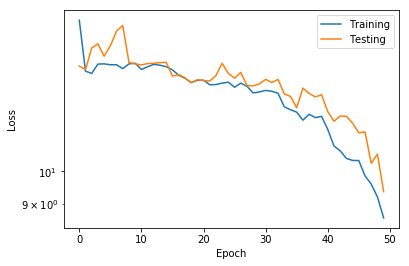

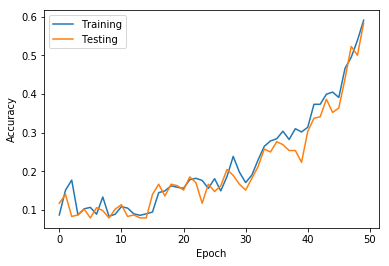

In [9]:
# Plot the results.
# Learning loss
plt.figure(1)
plt.semilogy(stats.training.lossLog, label='Training')
plt.semilogy(stats.testing .lossLog, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Learning accuracy
plt.figure(2)
plt.plot(stats.training.accuracyLog, label='Training')
plt.plot(stats.testing .accuracyLog, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Save training statistics

In [10]:
stats.save('Trained/')

## Generate Loihi parameters
Generate Loihi parameters i.e. weight files.

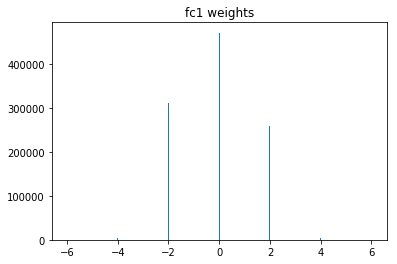

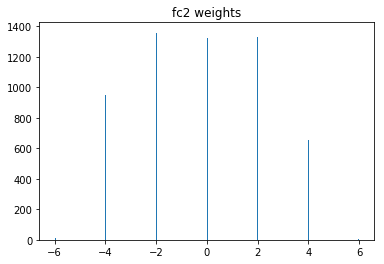

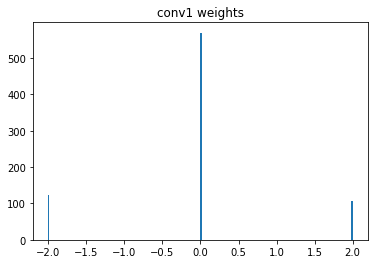

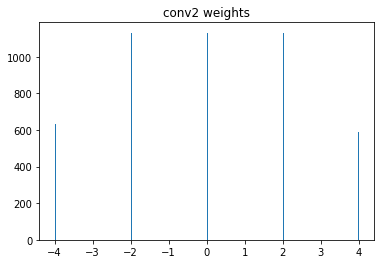

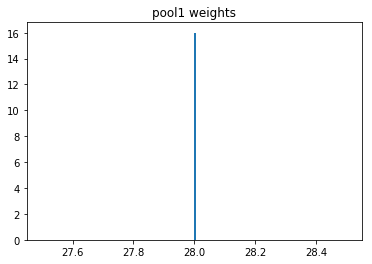

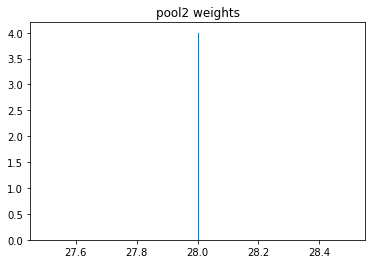

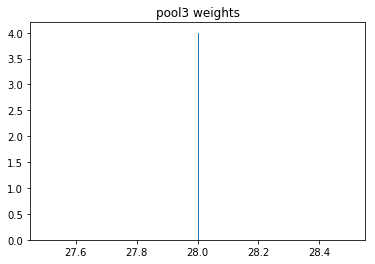

In [12]:
net.load_state_dict(torch.load('Trained/ibmGestureNet.pt'))
fc1Weights   = quantizeWeights.apply(net.fc1.weight  , 2).flatten().cpu().data.numpy()
fc2Weights   = quantizeWeights.apply(net.fc2.weight  , 2).flatten().cpu().data.numpy()
conv1Weights = quantizeWeights.apply(net.conv1.weight, 2).flatten().cpu().data.numpy()
conv2Weights = quantizeWeights.apply(net.conv2.weight, 2).flatten().cpu().data.numpy()
pool1Weights = quantizeWeights.apply(net.pool1.weight, 2).flatten().cpu().data.numpy()
pool2Weights = quantizeWeights.apply(net.pool2.weight, 2).flatten().cpu().data.numpy()
pool3Weights = quantizeWeights.apply(net.pool3.weight, 2).flatten().cpu().data.numpy()

np.save('Trained/fc1.npy'  , fc1Weights  )
np.save('Trained/fc2.npy'  , fc2Weights  )
np.save('Trained/conv1.npy', conv1Weights)
np.save('Trained/conv2.npy', conv2Weights)
np.save('Trained/pool1.npy', pool1Weights)
np.save('Trained/pool2.npy', pool2Weights)
np.save('Trained/pool3.npy', pool3Weights)

plt.figure(11)
plt.hist(fc1Weights  , 256)
plt.title('fc1 weights')

plt.figure(12)
plt.hist(fc2Weights  , 256)
plt.title('fc2 weights')

plt.figure(13)
plt.hist(conv1Weights, 256)
plt.title('conv1 weights')

plt.figure(14)
plt.hist(conv2Weights, 256)
plt.title('conv2 weights')

plt.figure(15)
plt.hist(pool1Weights, 256)
plt.title('pool1 weights')

plt.figure(16)
plt.hist(pool2Weights, 256)
plt.title('pool2 weights')

plt.figure(17)
plt.hist(pool3Weights, 256)
plt.title('pool3 weights')

plt.show()